In [59]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, r2_score
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [60]:
# Load data from SQLite database
query = 'SELECT * FROM sparkling_wine'
conn = sqlite3.connect('wine_database.db')
df = pd.read_sql_query(query, conn)
conn.close()

# Decode special characters
columns_to_decode = ['Name', 'Region', 'Winery']
for col in columns_to_decode:
    df[col] = df[col].str.encode('iso-8859-1').str.decode('utf-8')
   
df = df.drop(columns=['Name'])

# Separate categorical and numerical features
categorical_cols = ['Country', 'Region', 'Winery']
numerical_cols = ['Price', 'Year']

X = df[categorical_cols + numerical_cols]
y = df['Rating']
X

,Country,Region,Winery,Price,Year
0,France,Crémant de Loire,Langlois-Chateau,14.41,2017
1,New Zealand,Marlborough,Saint Clair,11.90,2019
2,Italy,Südtirol - Alto Adige,Kettmeir,21.50,2016
3,Germany,Baden,Griesel & Compagnie,22.13,2015
4,United States,Anderson Valley,Roederer Estate,57.51,2012
...,...,...,...,...,...
274,France,Champagne,Moët & Chandon,67.29,2009
275,France,Champagne,Louis Roederer,223.23,2007
276,France,Champagne,Bollinger,119.00,2007
277,France,Champagne,Taittinger,145.19,2006


In [61]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

# Combine training and test data to fit the encoder
X_combined = pd.concat([X_train, X_test], ignore_index=True)

# Create transformers for preprocessing
cat_transformer = OneHotEncoder(handle_unknown='ignore')
num_transformer = StandardScaler()

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_cols),
        ('num', num_transformer, numerical_cols)
    ]
)

# Fit and transform the combined dataset
X_combined_preprocessed = preprocessor.fit_transform(X_combined)

# Split the preprocessed data back into training and test datasets
X_train_preprocessed = X_combined_preprocessed[:len(X_train)]
X_test_preprocessed = X_combined_preprocessed[len(X_train):]

# Create XGBoost model
xgb_model = xgb.XGBRegressor()

# Fit the grid search to the preprocessed training data
xgb_model.fit(X_train_preprocessed, y_train)

# Make predictions on the preprocessed test data
predictions = xgb_model.predict(X_test_preprocessed)

# Calculate R-squared and Mean Squared Error
r2 = r2_score(y_test, predictions)
mse = mean_squared_error(y_test, predictions)

print(f"R-squared: {r2:.4f}")
print(f"Mean Squared Error: {mse:.4f}")

R-squared: 0.6563
Mean Squared Error: 0.0230


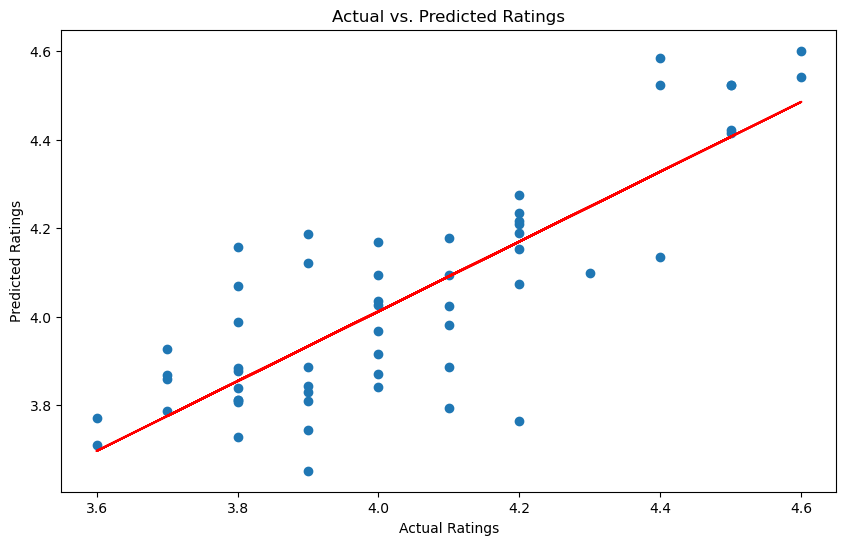

In [62]:

# Plot actual vs. predicted ratings
plt.figure(figsize=(10, 6))
plt.scatter(y_test, predictions)
slope, intercept = np.polyfit(y_test, predictions, 1)
plt.plot(y_test, slope * y_test + intercept, color='red')
plt.xlabel('Actual Ratings')
plt.ylabel('Predicted Ratings')
plt.title('Actual vs. Predicted Ratings')
plt.savefig('Sparkling_Actual_Predicted.png')
plt.show()

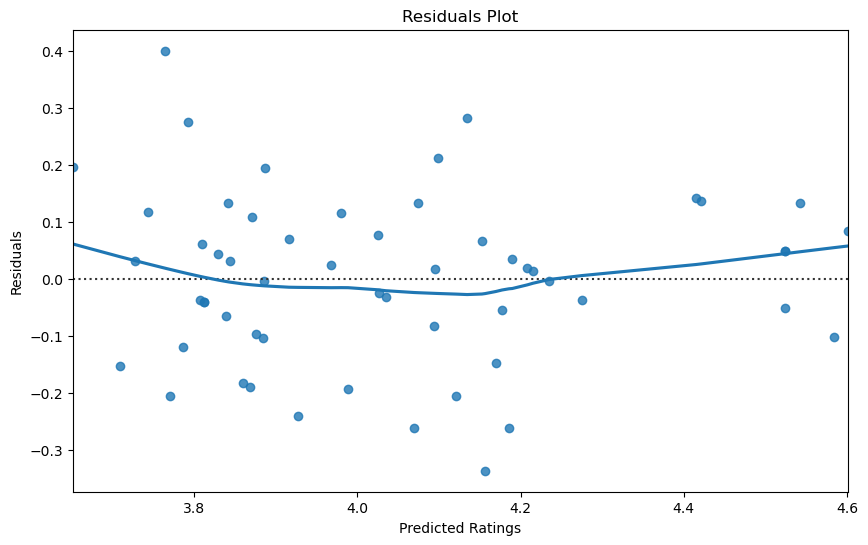

In [63]:

# Plot residuals
residuals = y_test - predictions
plt.figure(figsize=(10, 6))
sns.residplot(x=predictions, y=residuals, lowess=True)
plt.xlabel('Predicted Ratings')
plt.ylabel('Residuals')
plt.title('Residuals Plot')
plt.savefig('Sparkling_Residual.png')
plt.show()

In [64]:
Region_ratings = df.groupby("Region")["Rating"].mean()
Region_ratings

Region
Alta Langa                           3.750000
Anderson Valley                      4.100000
Asti                                 3.600000
Baden                                3.940000
Blanquette de Limoux                 3.700000
Brachetto d'Acqui                    4.000000
Burgenland                           4.300000
Cava                                 3.835714
Champagne                            4.338095
Champagne Grand Cru                  4.000000
Champagne Grand Cru 'Aÿ'             4.333333
Champagne Grand Cru 'Bouzy'          4.300000
Champagne Premier Cru                4.087500
Colli Orientali del Friuli           4.100000
Conegliano-Valdobbiadene Prosecco    3.872727
Contea di Sclafani                   3.900000
Crémant de Limoux                    3.600000
Crémant de Loire                     3.900000
Crémant du Jura                      3.700000
Douro                                4.050000
Emilia                               4.000000
Franciacorta               

In [65]:
Year_ratings = df.groupby("Year")["Rating"].mean()

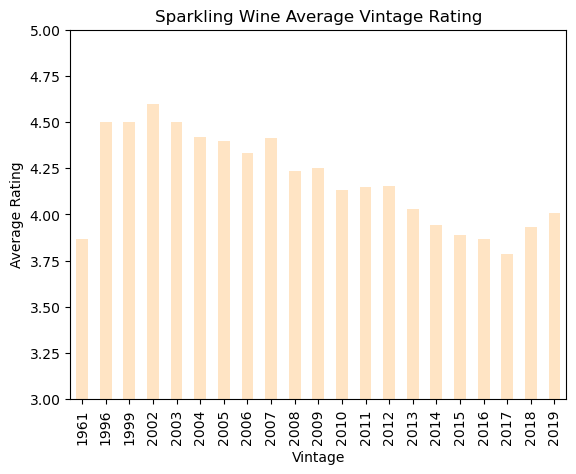

In [66]:
import matplotlib.pyplot as plt
plot_pandas = Year_ratings.plot.bar(color='bisque')
plt.title("Sparkling Wine Average Vintage Rating")
plt.xlabel('Vintage')
plt.ylabel('Average Rating')
plt.ylim(3, 5)
plt.show()

In [67]:
Rating_price = df.groupby("Rating")["Price"].mean()

C:\Users\Carrie Work\AppData\Local\Temp\ipykernel_24800\2644749565.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))


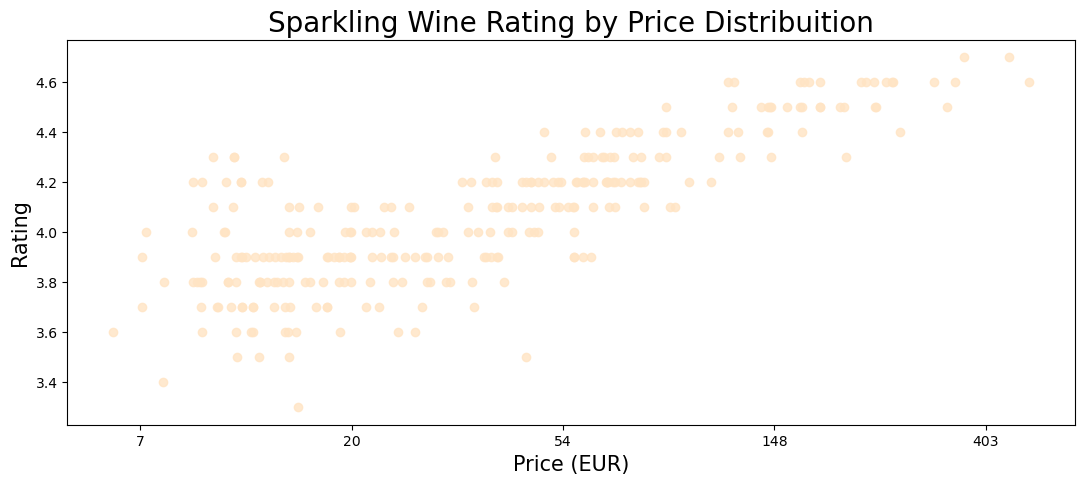

In [68]:
import seaborn as sns
plt.figure(figsize=(13,5))

graph = sns.regplot(x=np.log(df['Price']), y='Rating', 
                    data=df, fit_reg=False, color='bisque')
graph.set_title("Sparkling Wine Rating by Price Distribuition", fontsize=20)
graph.set_xlabel("Price (EUR)", fontsize= 15)
graph.set_ylabel("Rating", fontsize= 15)
graph.set_xticklabels(np.exp(graph.get_xticks()).astype(int))
plt.savefig('Sparkling_Price.png')
plt.show()